In [10]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#from ultralytics import YOLO
from collections import Counter
#import torch
from pathlib import Path
import csv

Now we can import the new images without the label of the bug.

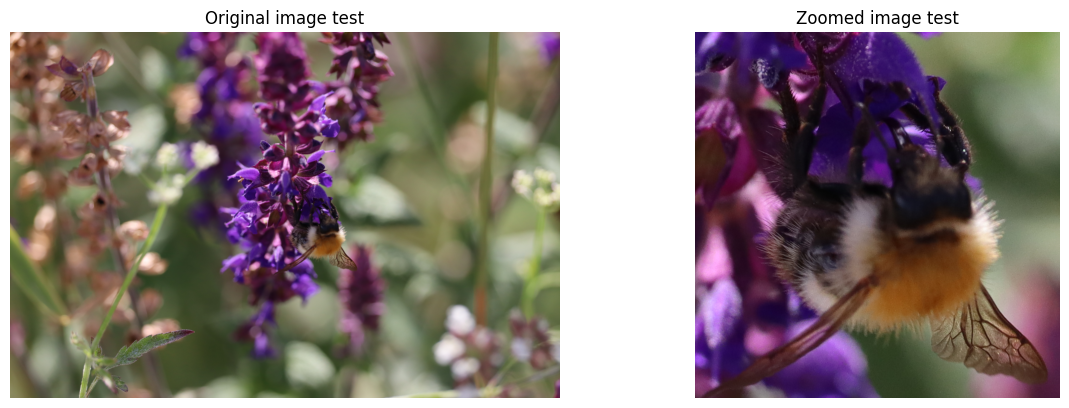

In [72]:
# Charger l'image de l'abeille et le masque
image = cv2.imread(r'C:\\Users\\marti\\OneDrive\\Martin OneDrive\\ISEP\\A2\\Semestre 2\\Ai and optimisation\\Projet\\train\\Test 23-05-2024\\Test\\test\\300.jpg')
mask = cv2.imread(r'C:\\Users\\marti\\OneDrive\\Martin OneDrive\\ISEP\\A2\\Semestre 2\\Ai and optimisation\\Projet\\train\\Test 23-05-2024\\Test\\test\\masks\\binary_300.tif', cv2.IMREAD_GRAYSCALE)

# Identifier la zone blanche de l'abeille dans le masque
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

# Déterminer les paramètres de zoom
zoom_factor = 1.05  # Choisissez le facteur de zoom selon vos préférences
zoomed_x = max(0, x - w * (zoom_factor - 1) / 2)
zoomed_y = max(0, y - h * (zoom_factor - 1) / 2)
zoomed_w = min(image.shape[1], w * zoom_factor)
zoomed_h = min(image.shape[0], h * zoom_factor)

# Appliquer les paramètres de zoom à l'image
zoomed_image = image[int(zoomed_y):int(zoomed_y + zoomed_h), int(zoomed_x):int(zoomed_x + zoomed_w)]

# Enlever le fond de l'image en utilisant le masque
masked_zoomed_image = cv2.bitwise_and(zoomed_image, zoomed_image, mask=mask[int(zoomed_y):int(zoomed_y + zoomed_h), int(zoomed_x):int(zoomed_x + zoomed_w)])

# Enregistrer l'image zoomée sans fond
cv2.imwrite('IMG_ZX_1.jpg', masked_zoomed_image)

# Afficher les quatre images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original image test')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(zoomed_image, cv2.COLOR_BGR2RGB))
plt.title('Zoomed image test')
plt.axis('off')


plt.tight_layout()
plt.show()

In [8]:
# Créer un dossier pour les images zoomées sans fond
output_folder = 'DATA_TEST_TRANSFORM'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
remaining_images = 0

# Parcourir les images d'abeille
for index, file in enumerate(os.listdir(r'C:\\Users\\marti\\OneDrive\\Martin OneDrive\\ISEP\\A2\\Semestre 2\\Ai and optimisation\\Projet\\train\\Test 23-05-2024\\Test\\test')):
    if file.endswith('.JPG'):  # Assurez-vous de sélectionner uniquement les fichiers JPG
        # Charger l'image de l'abeille
        image_path = os.path.join(r'C:\\Users\\marti\\OneDrive\\Martin OneDrive\\ISEP\\A2\\Semestre 2\\Ai and optimisation\\Projet\\train\\Test 23-05-2024\\Test\\test', file)
        image = cv2.imread(image_path)
        
        # Trouver le numéro de l'image pour correspondre au masque
        image_number = int(os.path.splitext(file)[0])
        
        # Charger le masque correspondant
        mask_path = os.path.join(r'C:\\Users\\marti\\OneDrive\\Martin OneDrive\\ISEP\\A2\\Semestre 2\\Ai and optimisation\\Projet\\train\\Test 23-05-2024\\Test\\test\\masks', f'binary_{image_number}.tif')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Identifier la zone blanche de l'abeille dans le masque
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Déterminer les paramètres de zoom
        zoom_factor = 1.05  # Choisissez le facteur de zoom selon vos préférences
        zoomed_x = max(0, x - w * (zoom_factor - 1) / 2)
        zoomed_y = max(0, y - h * (zoom_factor - 1) / 2)
        zoomed_w = min(image.shape[1], w * zoom_factor)
        zoomed_h = min(image.shape[0], h * zoom_factor)
        
        # Appliquer les paramètres de zoom à l'image
        zoomed_image = image[int(zoomed_y):int(zoomed_y + zoomed_h), int(zoomed_x):int(zoomed_x + zoomed_w)]
        
        # Enlever le fond de l'image en utilisant le masque
       # masked_zoomed_image = cv2.bitwise_and(zoomed_image, zoomed_image, mask=mask[int(zoomed_y):int(zoomed_y + zoomed_h), int(zoomed_x):int(zoomed_x + zoomed_w)])
        
        # Enregistrer l'image zoomée sans fond
        output_path = os.path.join(output_folder, f'{image_number}.jpg')
        if os.path.exists(output_path):
            os.remove(output_path)  # Supprimer l'ancienne image si elle existe
            
        cv2.imwrite(output_path, zoomed_image)

        # Afficher le compte à rebours
        remaining_images = remaining_images + 1
        print(f'{remaining_images} images ont été enregistrées. {image_number}')
        
print('Toutes les images dans le dossier ont été enregitrées')

1 images ont été enregistrées. 251
2 images ont été enregistrées. 252
3 images ont été enregistrées. 253
4 images ont été enregistrées. 254
5 images ont été enregistrées. 255
6 images ont été enregistrées. 256
7 images ont été enregistrées. 257
8 images ont été enregistrées. 258
9 images ont été enregistrées. 259
10 images ont été enregistrées. 260
11 images ont été enregistrées. 261
12 images ont été enregistrées. 262
13 images ont été enregistrées. 263
14 images ont été enregistrées. 264
15 images ont été enregistrées. 265
16 images ont été enregistrées. 266
17 images ont été enregistrées. 267
18 images ont été enregistrées. 268
19 images ont été enregistrées. 269
20 images ont été enregistrées. 270
21 images ont été enregistrées. 271
22 images ont été enregistrées. 272
23 images ont été enregistrées. 273
24 images ont été enregistrées. 274
25 images ont été enregistrées. 275
26 images ont été enregistrées. 276
27 images ont été enregistrées. 277
28 images ont été enregistrées. 278
2

In [2]:
results_path = './runs/classify/train7/results.csv'

results = pd.read_csv(results_path)

results

,epoch,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.69560,0.36923,0.98462,1.7445,0.000150,0.000150,0.000150
1,2,1.40160,0.46154,1.00000,1.6897,0.000299,0.000299,0.000299
2,3,1.00330,0.61538,1.00000,1.5474,0.000441,0.000441,0.000441
3,4,0.67384,0.80000,1.00000,1.3000,0.000575,0.000575,0.000575
4,5,0.45391,0.84615,1.00000,1.3047,0.000643,0.000643,0.000643
5,6,0.27213,0.83077,1.00000,1.3940,0.000626,0.000626,0.000626
6,7,0.29915,0.81538,1.00000,1.1902,0.000608,0.000608,0.000608
7,8,0.21325,0.87692,1.00000,1.1790,0.000590,0.000590,0.000590
8,9,0.11815,0.92308,1.00000,1.2311,0.000573,0.000573,0.000573
9,10,0.19097,0.80000,1.00000,1.2105,0.000555,0.000555,0.000555


In [3]:
model = YOLO('./runs/classify/train7/weights/last.pt')  # load a custom model

In [7]:
# Dossier contenant les images
image_folder = './DATA_TEST_TRANSFORM/'

# Fichier CSV de sortie
output_csv = 'predictions_species.csv'

# Liste pour stocker les résultats
results_list = []

In [82]:
# Parcourir toutes les images du dossier
for image_name in os.listdir(image_folder):
    if image_name.endswith(('.jpg')):  # Filtrer les fichiers d'image
        image_path = os.path.join(image_folder, image_name)
        
        # Faire la prédiction
        results = model(image_path)  # Prédire sur l'image
        
        # Extraire les noms des classes et les probabilités
        names_dict = results[0].names
        probs = results[0].probs.data.tolist()
        
        # Trouver la classe avec la probabilité la plus élevée
        max_index = np.argmax(probs)
        predicted_class = names_dict[max_index]
        #confidence = probs[max_index]
        
        # Extraire le numéro de l'image en supprimant '.jpg'
        image_number = image_name.replace('.jpg', '')
        
        # Ajouter les résultats à la liste
        results_list.append([image_number, predicted_class])
        
# Écrire les résultats dans un fichier CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Predicted Class'])
    writer.writerows(results_list)

print(f"Les résultats des prédictions ont été enregistrés dans {output_csv}.")


image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\251.jpg: 512x512 Bee 0.98, Butterfly 0.01, Hover fly 0.01, Bumblebee 0.01, Wasp 0.00, 51.8ms
Speed: 24.0ms preprocess, 51.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\252.jpg: 512x512 Bee 1.00, Butterfly 0.00, Bumblebee 0.00, Hover fly 0.00, Dragonfly 0.00, 50.1ms
Speed: 19.1ms preprocess, 50.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\253.jpg: 512x512 Bee 1.00, Hover fly 0.00, Bumblebee 0.00, Butterfly 0.00, Wasp 0.00, 42.3ms
Speed: 13.1ms preprocess, 42.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

imag


image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\276.jpg: 512x512 Bumblebee 1.00, Bee 0.00, Butterfly 0.00, Hover fly 0.00, Wasp 0.00, 61.9ms
Speed: 26.6ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\277.jpg: 512x512 Bumblebee 0.99, Bee 0.00, Butterfly 0.00, Hover fly 0.00, Wasp 0.00, 52.4ms
Speed: 32.6ms preprocess, 52.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\278.jpg: 512x512 Bumblebee 1.00, Bee 0.00, Butterfly 0.00, Hover fly 0.00, Dragonfly 0.00, 44.1ms
Speed: 31.1ms preprocess, 44.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

imag


image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\301.jpg: 512x512 Bumblebee 1.00, Hover fly 0.00, Bee 0.00, Butterfly 0.00, Wasp 0.00, 51.6ms
Speed: 23.6ms preprocess, 51.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\302.jpg: 512x512 Bee 1.00, Hover fly 0.00, Wasp 0.00, Butterfly 0.00, Bumblebee 0.00, 54.2ms
Speed: 30.6ms preprocess, 54.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\303.jpg: 512x512 Bee 0.95, Hover fly 0.04, Bumblebee 0.01, Wasp 0.01, Butterfly 0.00, 57.2ms
Speed: 22.1ms preprocess, 57.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1


image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\326.jpg: 512x512 Bumblebee 1.00, Butterfly 0.00, Hover fly 0.00, Wasp 0.00, Bee 0.00, 47.6ms
Speed: 34.6ms preprocess, 47.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\327.jpg: 512x512 Bumblebee 0.49, Bee 0.36, Hover fly 0.14, Dragonfly 0.00, Butterfly 0.00, 40.7ms
Speed: 27.6ms preprocess, 40.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 C:\Users\marti\OneDrive\Martin OneDrive\ISEP\A2\Semestre 2\Ai and optimisation\Projet\train\Test 23-05-2024\DATA_TEST_TRANSFORM\328.jpg: 512x512 Bumblebee 0.98, Bee 0.01, Hover fly 0.00, Butterfly 0.00, Wasp 0.00, 45.7ms
Speed: 22.6ms preprocess, 45.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

imag

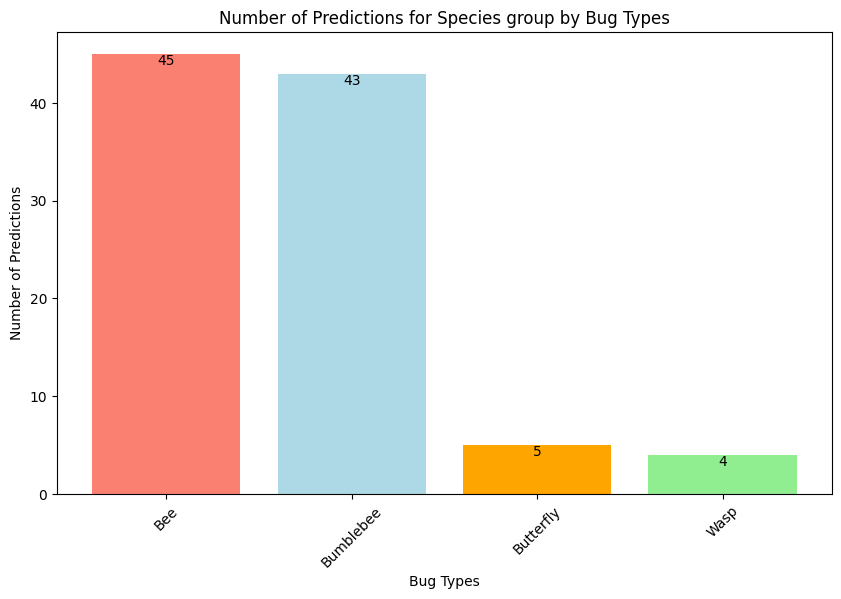

In [19]:
predictions = []
with open(output_csv, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        predictions.append(row['bug type'])

# Compter le nombre de prédictions pour chaque classe
prediction_counts = Counter(predictions)

# Trier les classes par ordre décroissant de fréquence
sorted_counts = prediction_counts.most_common()

# Séparer les noms des classes et les compteurs pour l'affichage
classes, counts = zip(*sorted_counts)

# Définir les couleurs spécifiques pour certaines classes
class_colors = {
    'Bee': 'salmon',
    'Bumblebee': 'lightblue',
    'Butterfly': 'orange',
    'Wasp': 'lightgreen',
    'Hover fly': 'thistle'
}

# Générer les couleurs pour les barres en utilisant les couleurs spécifiées
colors = [class_colors.get(class_name, 'grey') for class_name in classes]

# Générer l'histogramme
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=[class_colors[class_name] for class_name in classes])
plt.xlabel('Bug Types')
plt.ylabel('Number of Predictions')
plt.title('Number of Predictions for Species group by Bug Types')
plt.xticks(rotation=45)

# Ajouter des étiquettes de données sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='top')

# Afficher l'histogramme
plt.show()

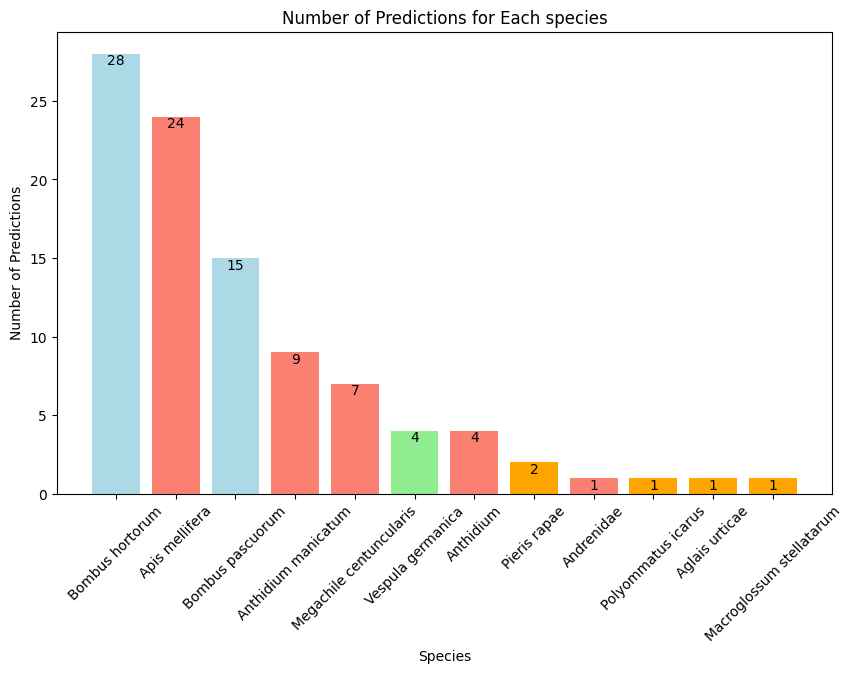

In [13]:
predictions = []
with open(output_csv, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        predictions.append(row['Predicted Class'])

# Compter le nombre de prédictions pour chaque classe
prediction_counts = Counter(predictions)

# Trier les classes par ordre décroissant de fréquence
sorted_counts = prediction_counts.most_common()

# Séparer les noms des classes et les compteurs pour l'affichage
classes, counts = zip(*sorted_counts)

# Définir les couleurs spécifiques pour certaines classes
class_colors = {
    'Apis mellifera': 'salmon',
    'Anthidium manicatum': 'salmon',
    'Andrenidae': 'salmon',
    'Megachile centuncularis': 'salmon',
    'Vespula germanica': 'lightgreen',
    'Bombus hortorum': 'lightblue',
    'Bombus pascuorum': 'lightblue',
    'Anthidium': 'salmon',
    'Polyommatus icarus': 'orange',
    'Aglais urticae': 'orange',
    'Pieris rapae': 'orange',
    'Macroglossum stellatarum': 'orange',
}

# Générer les couleurs pour les barres en utilisant les couleurs spécifiées
colors = [class_colors.get(class_name, 'grey') for class_name in classes]

# Générer l'histogramme
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=[class_colors[class_name] for class_name in classes])
plt.xlabel('Species')
plt.ylabel('Number of Predictions')
plt.title('Number of Predictions for Each species')
plt.xticks(rotation=45)

# Ajouter des étiquettes de données sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='top')

# Afficher l'histogramme
plt.show()

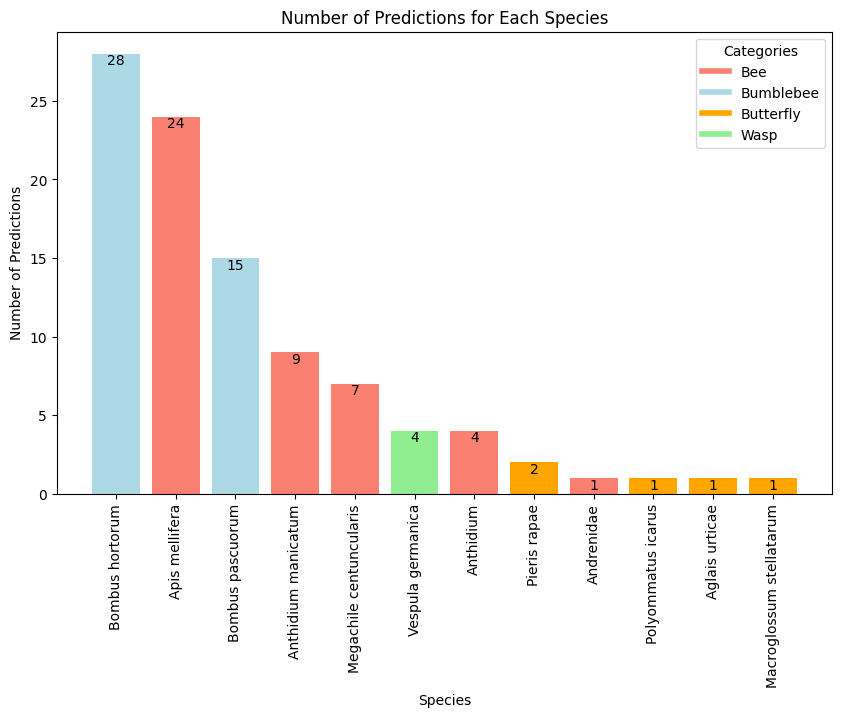

In [17]:
predictions = []
with open(output_csv, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        predictions.append(row['Predicted Class'])

# Compter le nombre de prédictions pour chaque classe
prediction_counts = Counter(predictions)

# Trier les classes par ordre décroissant de fréquence
sorted_counts = prediction_counts.most_common()

# Séparer les noms des classes et les compteurs pour l'affichage
classes, counts = zip(*sorted_counts)

# Définir les couleurs spécifiques pour certaines classes
class_colors = {
    'Apis mellifera': 'salmon',
    'Anthidium manicatum': 'salmon',
    'Andrenidae': 'salmon',
    'Megachile centuncularis': 'salmon',
    'Vespula germanica': 'lightgreen',
    'Bombus hortorum': 'lightblue',
    'Bombus pascuorum': 'lightblue',
    'Anthidium': 'salmon',
    'Polyommatus icarus': 'orange',
    'Aglais urticae': 'orange',
    'Pieris rapae': 'orange',
    'Macroglossum stellatarum': 'orange',
}

# Définir les couleurs de la légende
legend_colors = {
    'Bee': 'salmon',
    'Bumblebee': 'lightblue',
    'Butterfly': 'orange',
    'Wasp': 'lightgreen'
}

# Générer les couleurs pour les barres en utilisant les couleurs spécifiées
colors = [class_colors.get(class_name, 'grey') for class_name in classes]

# Générer l'histogramme
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=colors)
plt.xlabel('Species')
plt.ylabel('Number of Predictions')
plt.title('Number of Predictions for Each Species')
plt.xticks(rotation=90)

# Ajouter des étiquettes de données sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='top')

# Ajouter la légende
legend_labels = list(legend_colors.keys())
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors.values()]
plt.legend(legend_handles, legend_labels, title='Categories', loc='upper right')

# Afficher l'histogramme
plt.show()

In [78]:
from collections import defaultdict
predictions = defaultdict(list)
with open(output_csv, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        class_name = row['Predicted Class']
        confidence = float(row['Confidence'])
        predictions[class_name].append(confidence)

# Calculer le pourcentage moyen de confiance pour chaque classe
average_confidences = {class_name: sum(confidences) / len(confidences)
                       for class_name, confidences in predictions.items()}

# Trier les classes par ordre décroissant de confiance moyenne
sorted_avg_confidences = sorted(average_confidences.items(), key=lambda x: x[1], reverse=True)

# Séparer les noms des classes et les moyennes pour l'affichage
classes, avg_confidences = zip(*sorted_avg_confidences)

# Définir les couleurs spécifiques pour certaines classes
class_colors = {
    'Bee': 'salmon',
    'Bumblebee': 'lightblue',
    'Butterfly': 'orange',
    'Wasp': 'lightgreen',
    'Hover fly': 'thistle'
}

# Générer les couleurs pour les barres en utilisant les couleurs spécifiées
colors = [class_colors.get(class_name, 'grey') for class_name in classes]

# Générer l'histogramme
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, avg_confidences, color=colors)
plt.xlabel('Bug Types')
plt.ylabel('Average Confidence')
plt.title('Average Confidence of Predictions for Each Bug Type')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Les pourcentages de confiance sont entre 0 et 1

# Ajouter des étiquettes de données sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='top')

# Afficher l'histogramme
plt.show()

KeyError: 'Confidence'

In [6]:
import pandas as pd

# Étape 1 : Charger les fichiers CSV
# Charger les prédictions manuelles
predictions_hand_df = pd.read_csv('./predictions_hand.csv')

# Charger les prédictions automatiques
predictions_df = pd.read_csv('./predictions_species.csv')

# Afficher les premières lignes de chaque DataFrame pour vérifier le contenu
print("Prédictions manuelles :")
print(predictions_hand_df.head())
print("\nPrédictions automatiques :")
print(predictions_df.head())

# Étape 2 : Comparer les prédictions
# Vérifier si la colonne 'Predicted Class' des deux DataFrames est égale
correct_predictions = (predictions_hand_df['bug type'] == predictions_df['bug type']).sum()

# Calculer le nombre total de prédictions
total_predictions = len(predictions_hand_df)

# Étape 3 : Calculer le pourcentage de bonnes prédictions
accuracy_percentage = (correct_predictions / total_predictions) * 100

# Afficher le résultat
print(f"Le pourcentage de bonnes prédictions est de {accuracy_percentage:.2f}%.")


Prédictions manuelles :
  Image Name bug type  Confidence
0    251.jpg      Bee    0.976179
1    252.jpg      Bee    0.997266
2    253.jpg      Bee    0.997656
3    254.jpg      Bee    0.997047
4    255.jpg      Bee    0.983708

Prédictions automatiques :
        ID Predicted Class  Confidence bug type
0  251.jpg  Apis mellifera    0.826357      Bee
1  252.jpg  Apis mellifera    0.459595      Bee
2  253.jpg  Apis mellifera    0.637950      Bee
3  254.jpg  Apis mellifera    0.955285      Bee
4  255.jpg  Apis mellifera    0.892442      Bee
Le pourcentage de bonnes prédictions est de 88.66%.


In [33]:
import pandas as pd

# Étape 1 : Charger les fichiers CSV
# Charger les prédictions manuelles
predictions_hand_df = pd.read_csv('./predictions_hand_3classes.csv')

# Charger les prédictions automatiques
predictions_df = pd.read_csv('./predictions_3classes.csv')

# Afficher les premières lignes de chaque DataFrame pour vérifier le contenu
print("Prédictions manuelles :")
print(predictions_hand_df.head())
print("\nPrédictions automatiques :")
print(predictions_df.head())

# Étape 2 : Comparer les prédictions
# Vérifier si la colonne 'Predicted Class' des deux DataFrames est égale
correct_predictions = (predictions_hand_df['Predicted Class'] == predictions_df['Predicted Class']).sum()

# Calculer le nombre total de prédictions
total_predictions = len(predictions_hand_df)

# Étape 3 : Calculer le pourcentage de bonnes prédictions
accuracy_percentage = (correct_predictions / total_predictions) * 100

# Afficher le résultat
print(f"Le pourcentage de bonnes prédictions est de {accuracy_percentage:.2f}%.")

Prédictions manuelles :
  Image Name Predicted Class  Confidence
0    251.jpg             Bee    0.976179
1    252.jpg             Bee    0.997266
2    253.jpg             Bee    0.997656
3    254.jpg             Bee    0.997047
4    255.jpg             Bee    0.983708

Prédictions automatiques :
  Image Name Predicted Class  Confidence
0    251.jpg             Bee    0.996779
1    252.jpg             Bee    0.998126
2    253.jpg             Bee    0.995555
3    254.jpg             Bee    0.998200
4    255.jpg             Bee    0.999940
Le pourcentage de bonnes prédictions est de 87.63%.


In [9]:
from ultralytics import YOLO


# Run batched inference on a list of images
results = model(["259.jpg","278.jpg", "273.jpg","325.jpg", "340.jpg"])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk


0: 512x512 Bee 1.00, Hover fly 0.00, Bumblebee 0.00, Butterfly 0.00, Wasp 0.00, 34.8ms
1: 512x512 Bumblebee 1.00, Bee 0.00, Butterfly 0.00, Hover fly 0.00, Dragonfly 0.00, 34.8ms
2: 512x512 Wasp 1.00, Hover fly 0.00, Bee 0.00, Bumblebee 0.00, Dragonfly 0.00, 34.8ms
3: 512x512 Butterfly 0.99, Bee 0.00, Bumblebee 0.00, Dragonfly 0.00, Wasp 0.00, 34.8ms
4: 512x512 Butterfly 1.00, Bee 0.00, Dragonfly 0.00, Bumblebee 0.00, Hover fly 0.00, 34.8ms
Speed: 27.6ms preprocess, 34.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


In [10]:
from PIL import Image
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

In [17]:
# List of image paths
image_paths = ["259.jpg", "278.jpg", "273.jpg", "325.jpg", "340.jpg"]

# Run batched inference on the list of images
results = model(image_paths)  # return a list of Results objects

# Process results list
for i, result in enumerate(results):
    # Load the original image
    img = cv2.imread(image_paths[i])

    # Draw the YOLO results on the image
    result_plotted = result.plot()  # Assuming `result.plot()` returns an image with plotted results

    # Convert the image from BGR to RGB
    result_plotted_rgb = cv2.cvtColor(result_plotted, cv2.COLOR_BGR2RGB)
    
    # Add the image name at the top of the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = image_paths[i]
    font_scale = 2
    color = (255, 255, 255)  # White color
    thickness = 5
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_x = (result_plotted_rgb.shape[1] - text_size[0]) // 2
    text_y = text_size[1] + 10  # 10 pixels from the top

    # Draw the text on the image
    cv2.putText(result_plotted_rgb, text, (text_x, text_y), font, font_scale, color, thickness)

    # Convert the image back from RGB to BGR
    result_plotted_bgr = cv2.cvtColor(result_plotted_rgb, cv2.COLOR_RGB2BGR)
    
    # Save the image with the text
    output_filename = f"result_{text}"
    cv2.imwrite(output_filename, result_plotted_bgr)


0: 512x512 Bee 1.00, Hover fly 0.00, Bumblebee 0.00, Butterfly 0.00, Wasp 0.00, 33.8ms
1: 512x512 Bumblebee 1.00, Bee 0.00, Butterfly 0.00, Hover fly 0.00, Dragonfly 0.00, 33.8ms
2: 512x512 Wasp 1.00, Hover fly 0.00, Bee 0.00, Bumblebee 0.00, Dragonfly 0.00, 33.8ms
3: 512x512 Butterfly 0.99, Bee 0.00, Bumblebee 0.00, Dragonfly 0.00, Wasp 0.00, 33.8ms
4: 512x512 Butterfly 1.00, Bee 0.00, Dragonfly 0.00, Bumblebee 0.00, Hover fly 0.00, 33.8ms
Speed: 31.6ms preprocess, 33.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
